In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Ideas

Exploration:

- correlation to payment/product tier
- feature usage (havy recurring usage less likely to churn? donor logins less likely to churn? low broad usage of features more likely to churn?)
- time on platform? (less than 12 months live on platform? 12 to 24 months? 24 to 36 months?)
- processing volume (more likely to churn when processing under \\$50k per year? \\$100k?)
- CX touches (more interaction with CX or less compared to churn and non-churn)
- transaction growth (if they are not growing, perhaps they change platforms because they have no other ideas and blame the platform?)
- time of year (is churn more likely in predictabl annual patterns?)

Potential leading indicators:

- processing dropoff
- CP activity dropoff
- login frequency decrease or increase (may increase as they are transitioning settings or decrease after they have been transferred and are actively transitioning activity to the new platform)

# Transactions exploration

__Hypothesis__ It would stand to reason that an organization preparing to change fundraising platforms might experience some wind down period in processing volume. The presumed operational flow would be that the client implements another solution and begins redirecting traffic and transactions to the new platform prior to actually closing the current account. I would assume at the very least that they would redirect one time transactions first, probably over night in a single web site change, but recurring or event registrations might continue in the current platform until they had verified the new platform. If this is correct, we should see one time transactions drop off sharply while recurring or event registrations decrease progressively approaching the termination of all processing.

In [2]:
TRANS_PATH = "transactions.csv"

In [3]:
trans = pd.read_csv(TRANS_PATH)

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
trans["date"] = pd.to_datetime(trans['date'])
trans = trans[trans['status']=='A']
trans['year'] = trans['date'].dt.year
trans['month'] = trans['date'].dt.month
trans = trans[trans['year']!=2019]

aggs = {'amount': 'sum', 'recurring': 'sum', 'donations_count': 'sum', 'events_count': 'sum', 'registrations_count': 'sum'}
trans_agg = trans.groupby(['org', 'year', 'month']).agg(aggs).reset_index().sort_values(['org', 'year', 'month'], ascending=True)

In [5]:
trans_agg.head()

,org,year,month,registrations_count,amount,recurring,donations_count,events_count
0,0,2009,2,0,0.0,0,0,0
1,0,2009,4,0,50.0,1395,0,0
2,0,2009,5,0,50.0,1414,0,0
3,0,2009,7,0,50.0,1395,0,0
4,0,2009,10,0,50.0,1395,0,0


In [6]:
last_12_months_data = []

for o in trans_agg["org"].unique():
    _trans_agg = trans_agg[trans_agg['org']==o]
    last_12_months_data.append(_trans_agg.tail(12))

In [7]:
last_year = None
for i in last_12_months_data:
    if last_year is None:
        last_year = pd.DataFrame(i)
    else:
        last_year = last_year.append(pd.DataFrame(i))

In [8]:
last_year.head()

,org,year,month,registrations_count,amount,recurring,donations_count,events_count
0,0,2009,2,0,0.0,0,0,0
1,0,2009,4,0,50.0,1395,0,0
2,0,2009,5,0,50.0,1414,0,0
3,0,2009,7,0,50.0,1395,0,0
4,0,2009,10,0,50.0,1395,0,0


In [9]:
def plot_padded_data(df, col, plot=True):
    data_amount = {}

    for o in last_year.org.unique():
        amount_vals = last_year[last_year['org']==o][col].tolist()
        data_amount[o] = ((12 - len(amount_vals)) * [np.mean(amount_vals)]) + amount_vals
        
    df_amounts = pd.DataFrame(data_amount.values())
    means = df_amounts.mean()
    if plot:
        means.plot(figsize=(15,3))
    else:
        return means

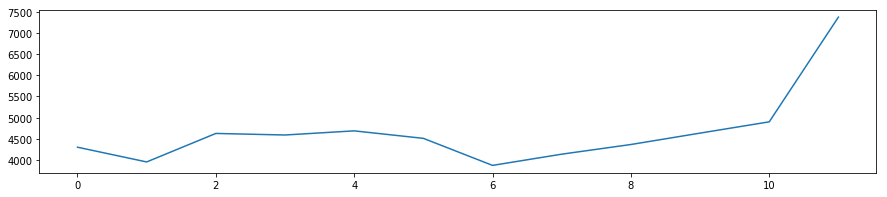

In [10]:
plot_padded_data(last_year, "amount")

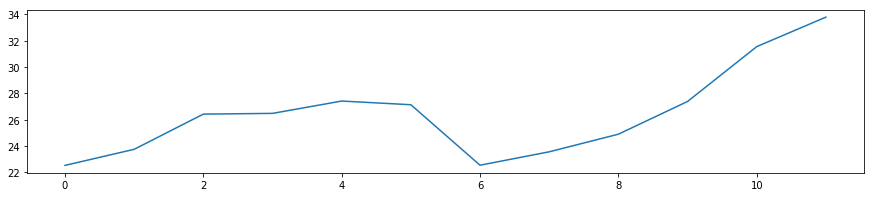

In [11]:
plot_padded_data(last_year, "donations_count")

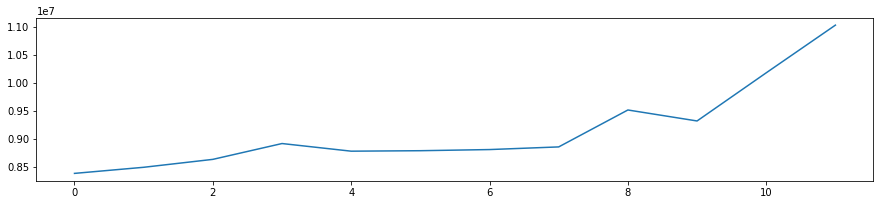

In [12]:
plot_padded_data(last_year, "recurring")

It appears in examining the transaction means (volume and count) that everything drop offs sharply at the end but continues to rise organically building up to it. _The important caveat here is that these are mean values, so this could be skewed by padded 0's and outliers._ I will try altering the data in two ways to verify this result:

1. We will remove all organizations with less than 12 months data so that the data is not skewed by the 0 padding
2. We will normalize the data in order to remove the influence of outliers

## Removing organizations with less than 12 months data

In [13]:
def plot_data(df, col, plot=True):
    data_amount = {}

    for o in last_year.org.unique():
        amount_vals = last_year[last_year['org']==o][col].tolist()
        if (len(amount_vals) == 12):
            data_amount[o] = amount_vals
        
    df_amounts = pd.DataFrame(data_amount.values())
    means = df_amounts.mean()
    if plot:
        means.plot(figsize=(15,3))
    else:
        return means

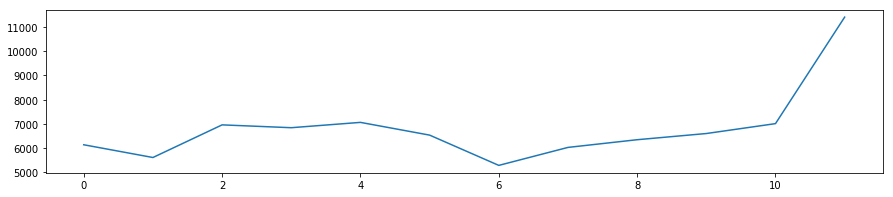

In [14]:
plot_data(last_year, "amount")

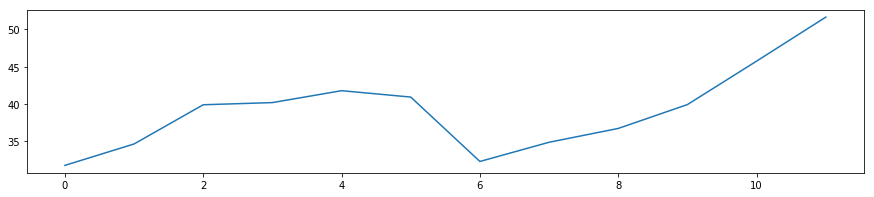

In [15]:
plot_data(last_year, "donations_count")

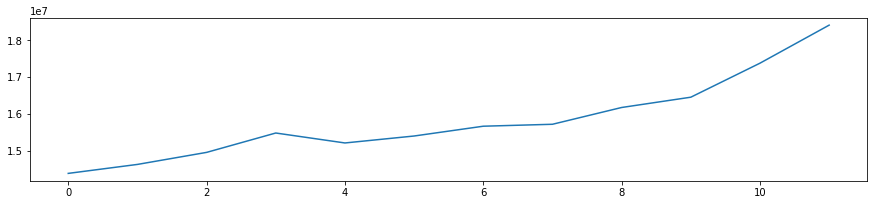

In [16]:
plot_data(last_year, "recurring")

__Examining the data without the 0-padded entries does not meaningfully change the trends.__

## Normalizing the data

In [17]:
def plot_normalized_data(df, col, plot=True):
    data_amount = {}

    for o in last_year.org.unique():
        amount_vals = last_year[last_year['org']==o][col].tolist()
        if (len(amount_vals) == 12):
            data_amount[o] = amount_vals / np.linalg.norm(amount_vals)
        
    df_amounts = pd.DataFrame(data_amount.values())
    means = df_amounts.mean()
    if plot:
        means.plot(figsize=(15,3))
    else:
        return means

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


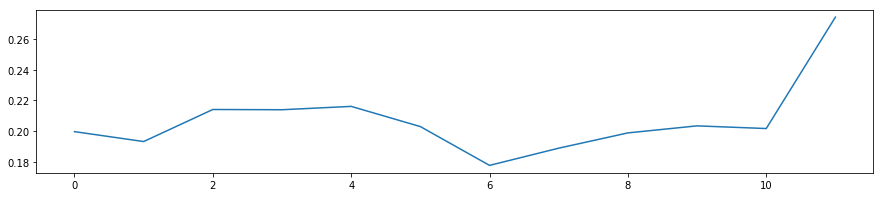

In [18]:
plot_normalized_data(last_year, "amount")

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


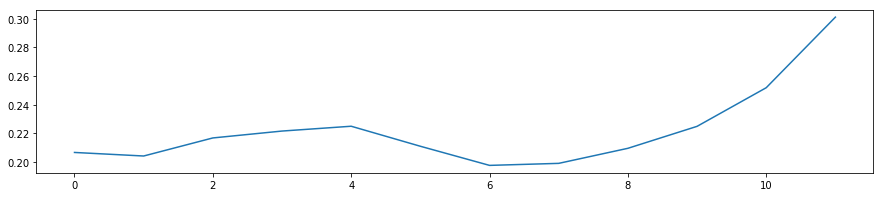

In [19]:
plot_normalized_data(last_year, "donations_count")

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


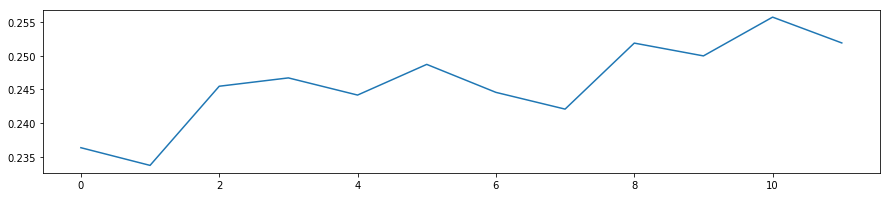

In [20]:
plot_normalized_data(last_year, "recurring")

The normalized data with 0-padded entries removed had nearly identical trends to the others, so __it appears that the transaction data does not contain a meaningful churn notification.__ 

This data does include all forms, so it is highly likely that the views of the data rendered here are largely that of the 2018 processing year for all forms, thus we see the processing rise to the end of the visualized dataset. We need to visualize the __closed__ orgs in isolation in order to verify the lack of indicative trend.

## Isolating closed orgs

In [71]:
ORGANIZATION_IDS = "organizations.csv"

df_orgs = pd.read_csv(ORGANIZATION_IDS)

df_orgs_cols = ["Id", "Org Name", "Date Closed", "Go Live Date"]

df_orgs = df_orgs[df_orgs_cols]
df_orgs["Date Closed"] = pd.to_datetime(df_orgs["Date Closed"])
df_orgs["Go Live Date"] = pd.to_datetime(df_orgs["Go Live Date"])
df_orgs.head()

,Id,Date Closed,Go Live Date
0,441789,NaT,1969-12-31
1,443044,NaT,1969-12-31
2,1045,2011-06-30,2011-03-14
3,442134,NaT,2017-11-06
4,442293,NaT,2018-01-29


In [72]:
null_closed_orgs = len(df_orgs[df_orgs["Date Closed"].isnull()])
len_orgs = len(df_orgs)
null_perc = (float(null_closed_orgs) / float(len_orgs)) * 100
"{:.2f}% orgs not closed of {}".format(null_perc, len_orgs)

'77.87% orgs not closed of 6701'

In [73]:
closed_orgs = df_orgs[~df_orgs["Date Closed"].isnull()]['Id'].tolist()

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


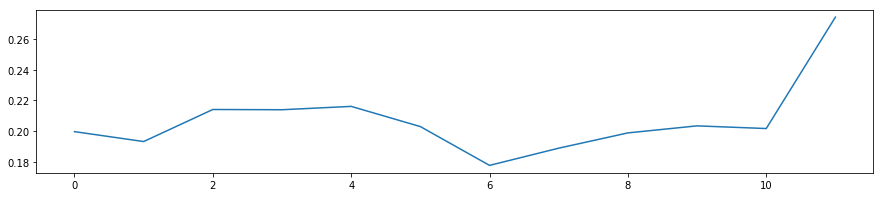

In [74]:
plot_normalized_data(last_year[last_year['org'].isin(closed_orgs)], "amount")

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


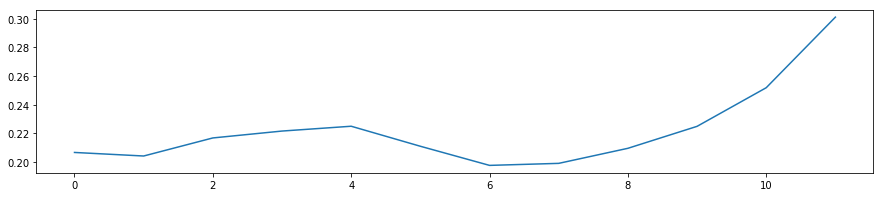

In [75]:
plot_normalized_data(last_year[last_year['org'].isin(closed_orgs)], "donations_count")

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


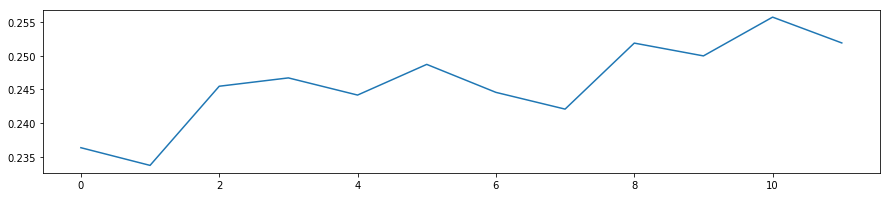

In [76]:
plot_normalized_data(last_year[last_year['org'].isin(closed_orgs)], "recurring")

It appears that isolating orgs with closed dates does not meaningfully alter the processing trend. Transaction activity does not appear to be a leading indicator of churn.

In [27]:
# isolating form IDs mapped to org IDs from transactions
form_orgs_map = trans[["form", "org"]].groupby("form")['org'].first().reset_index()

# Analytics

Here we will examine the characteristics of churning clients from the form analytics data. 

__Hypothesis__: we assume that churning clients will experience a wind down period where in they are either (1) removing or disabling setting from their form or (2) not creating them at the same frequency as before as they are shifting resources to the new platform.

__Data notes__: The analytics data does not contain a usable flag to identify closed accounts. We will identify these by a separate dataset containing organization ID's, status and date closed (_analytics/organizations.csv_).

In [28]:
ANALYTICS_BASE_PATH = "analytic_base.csv"

ANALYTICS_QGIV_PATH = "analytics/analytic_qgiv.csv"
ANALYTICS_P2P_PATH = "analytics/analytic_p2p.csv"

In [29]:
def get_org_id(form_id):
    if len(form_orgs_map[form_orgs_map['form']==form_id]['org']) > 0:
        return form_orgs_map[form_orgs_map['form']==form_id]['org'].iloc[0]
    else:
        return None

df_base = pd.read_csv(ANALYTICS_BASE_PATH)
#df_base['org'] = df_base['entity'].apply(get_org_id)
#df_base.to_csv(ANALYTICS_BASE_PATH)

In [30]:
df_base["date"] = pd.to_datetime(df_base["tm_stamp"])
df_base['form'] = df_base['entity']
drop_cols = ["tm_stamp", "entity", "entityType", "sic", "path", "visits", "ein", "kiosk_trans_vol", "kiosk_trans_count", "givi_trans_count", "givi_trans_vol", "fb_trans_vol", "fb_trans_count"]
df_base.drop(drop_cols, axis=1, inplace=True)
df_base.head()

,Unnamed: 0,don_form_trans_count,don_form_trans_vol,id,ids,mobile_trans_count,mobile_trans_vol,mobile_visits,mobilevt_trans_count,mobilevt_trans_vol,...,product,rec_trans_count,rec_trans_vol,sms_trans_count,sms_trans_vol,vt_trans_count,vt_trans_vol,org,date,form
0,0,0,0.0,47131755,"47131755,47101203,47116475,47147054",0,0.0,0,0,0.0,...,1.0,0,0.0,0,0.0,0,0.0,NaN,2018-06-27,934771
1,1,0,0.0,44787400,"44787400,44772720,44758040,44802081",0,0.0,0,0,0.0,...,1.0,0,0.0,0,0.0,0,0.0,NaN,2018-05-19,934771
2,2,0,0.0,44137209,"44137209,44122731,44151693,44166184",0,0.0,0,0,0.0,...,1.0,0,0.0,0,0.0,0,0.0,NaN,2018-05-08,934771
3,3,0,0.0,45558379,"45558379,45573358,45528482,45543427",0,0.0,0,0,0.0,...,1.0,0,0.0,0,0.0,0,0.0,NaN,2018-06-01,934771
4,4,0,0.0,44860872,"44860872,44816762,44831443,44846146",0,0.0,0,0,0.0,...,1.0,0,0.0,0,0.0,0,0.0,NaN,2018-05-20,934771


In [31]:
null_orgs = len(df_base[df_base['org'].isnull()])
len_entries = len(df_base)
null_perc = (float(null_orgs) / float(len_entries)) * 100
"{:.2f}% null org entries out of {}".format(null_perc, len_entries)

'27.89% null org entries out of 4500045'

In [32]:
# narrow dataset to non-null org entries
df_base_nn = df_base[~df_base['org'].isnull()]

In [33]:
closed_orgs = df_orgs[~df_orgs["Date Closed"].isnull()]['Id'].tolist()
open_orgs = df_orgs[df_orgs["Date Closed"].isnull()]["Id"].tolist()

print("{} closed orgs; {} open orgs".format(len(closed_orgs), len(open_orgs)))

1419 closed orgs; 4807 open orgs


In [77]:
churned_orgs_df = df_orgs[~df_orgs["Date Closed"].isnull()]
churned_orgs_df['Date Closed'] = pd.to_datetime(churned_orgs_df['Date Closed'])
churned_orgs_df['churn_month'] = churned_orgs_df['Date Closed'].dt.month
churned_orgs_df['churn_year'] = churned_orgs_df['Date Closed'].dt.year

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [78]:
churned_orgs_df['churn_month'].value_counts()

4     166
7     162
1     151
6     140
3     129
5     120
12    119
10    115
11    109
2     104
8     102
9      66
Name: churn_month, dtype: int64

In [79]:
churned_orgs_df['churn_year'].value_counts()

2018    324
2017    218
2014    216
2011    131
2012    122
2016    111
2013     99
2010     76
2019     63
2015     56
2009     46
2008     17
2007      4
Name: churn_year, dtype: int64

There isn't any clear dominant month but I would like to see the year over year churn rates to find out if there are any high or low churn years. It does appear that 2015 was an unusually low year.

In [81]:
df_orgs['Go Live Date'] = pd.to_datetime(df_orgs['Go Live Date'])
df_orgs['first_active_year'] = df_orgs['Go Live Date'].dt.year
df_orgs['Date Closed'] = pd.to_datetime(df_orgs['Date Closed'])
df_orgs['churn_year'] = df_orgs['Date Closed'].dt.year

,Id,Date Closed,Go Live Date,first_active_year,churn_year
0,441789,NaT,1969-12-31,1969,NaN
1,443044,NaT,1969-12-31,1969,NaN
2,1045,2011-06-30,2011-03-14,2011,2011.0
3,442134,NaT,2017-11-06,2017,NaN
4,442293,NaT,2018-01-29,2018,NaN


In [113]:
# df_orgs.to_csv("/Users/jeremyvanvalkenburg/Repositories/datasets/churn/churned_orgs.csv", index=False)

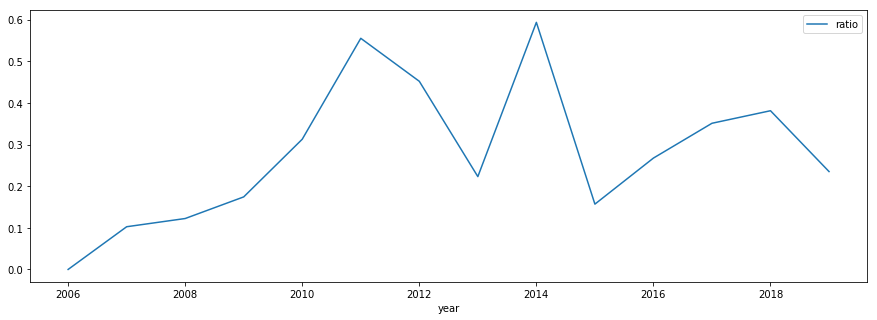

In [111]:
churn_rate_data = []
for y in df_orgs['first_active_year'].unique():
    churn_rate_data.append({
        "year": y,
        "joined": len(df_orgs[df_orgs['first_active_year']==y]),
        "churned": len(df_orgs[df_orgs['churn_year']==y])
    })

churn_rate_df = pd.DataFrame(churn_rate_data)
churn_rate_df = churn_rate_df[churn_rate_df['year']>=2006].sort_values('year', ascending=True)
churn_rate_df['ratio'] = churn_rate_df['churned'] / churn_rate_df['joined']
churn_rate_df[['ratio', 'year']].plot(x="year", figsize=(15,5))

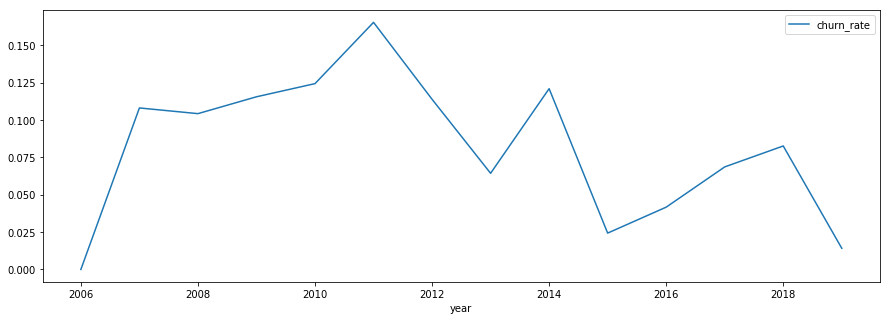

In [110]:
churn_rate_df['active_orgs'] = churn_rate_df['joined'].cumsum() - churn_rate_df['churned']
churn_rate_df['churn_rate'] = churn_rate_df['churned'] / churn_rate_df['active_orgs']
churn_rate_df[['year', 'churn_rate']].plot(x="year", figsize=(15,5))

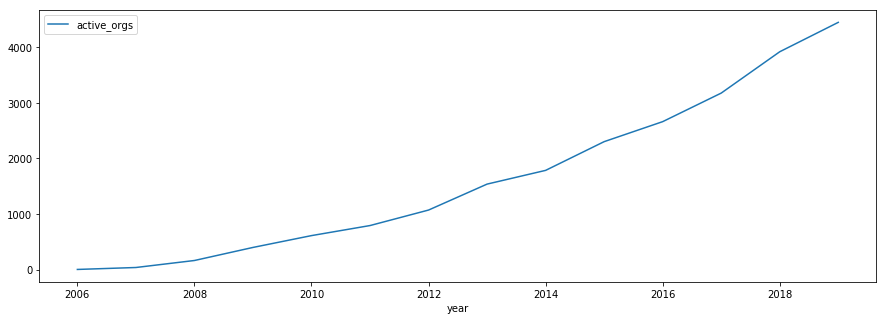

In [109]:
churn_rate_df[['active_orgs', 'year']].plot(x="year", figsize=(15,5))

## Settings

Look at the correlation between form settings and closed orgs. Ie, are churned orgs more or less likely to use a given feature than non-churned org's? This will be evaluated by simulation through transaction source counts.

In [34]:
df_base_churned = df_base[df_base.org.isin(closed_orgs)]
df_base_nonchurned = df_base[df_base.org.isin(open_orgs)]

cols_to_check = ["don_form_trans_count", "mobile_trans_count", "mobilevt_trans_count", "one_time_trans_count", "rec_trans_count", "p2p_trans_count", "sms_trans_count", "vt_trans_count"]

In [35]:
df_base_churned[cols_to_check].mean()

don_form_trans_count    0.033373
mobile_trans_count      0.015670
mobilevt_trans_count    0.001526
one_time_trans_count    0.033373
rec_trans_count         0.018466
p2p_trans_count         0.065974
sms_trans_count         0.004268
vt_trans_count          0.014307
dtype: float64

In [36]:
df_base_nonchurned[cols_to_check].mean()

don_form_trans_count    0.127019
mobile_trans_count      0.024052
mobilevt_trans_count    0.003858
one_time_trans_count    0.127019
rec_trans_count         0.081495
p2p_trans_count         0.067345
sms_trans_count         0.003408
vt_trans_count          0.014474
dtype: float64

It appears that for most transaction sources, non-churned org's are meaningfully higher. Specifically we can see that __one time and recurring transaction counts for non-churned org's are about 4 times greater than the churned org's__. The notable exceptions of P2P, SMS, and VT. A few theories here might be that

1. SMS and VT are specific application product categories, so the client may have signed up for this specific feature with no intention of broad implementation
2. P2P is a seasonal product and the client may exhibit low platform loyalty year over year
3. P2P, SMS and VT are ephemeral/circumstantial with low investment applications so clients using these without year round implementation may find it much easier to transition platforms

Things to explore:

1. Churn distribution of for org's using only these products (P2P, SMS, VT)
2. Churn distribution by processing volume

### Looking at churn distributions for particular settings

In [38]:
org_settings = df_base.groupby('org')[cols_to_check].mean().reset_index()
org_settings['churned'] = org_settings['org'].isin(closed_orgs)
org_settings.head()

,org,don_form_trans_count,mobile_trans_count,mobilevt_trans_count,one_time_trans_count,rec_trans_count,p2p_trans_count,sms_trans_count,vt_trans_count,churned
0,6.0,0.384855,0.161826,0.043568,0.384855,0.031120,0.000000,0.012448,0.621369,False
1,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False
2,13.0,0.044520,0.006554,0.030282,0.044520,0.006328,0.060113,0.005424,0.009266,False
3,31.0,0.404762,0.000000,0.000000,0.404762,0.031250,0.000000,0.000000,0.000000,False
4,33.0,0.053828,0.008373,0.000000,0.053828,0.139952,0.000000,0.000000,0.001196,False


In [53]:
# now split by sms, vt, and p2p to see how many with non-zero values have churned
msk_p2p = org_settings['p2p_trans_count']>0.
msk_vt = org_settings['vt_trans_count']>0.
msk_sms = org_settings['sms_trans_count']>0.

print("Broad churn rate: {:.5f}".format(org_settings['churned'].mean()))
print("P2P: {:.5f}".format(org_settings[msk_p2p]['churned'].mean()))
print("SMS: {:.5f}".format(org_settings[msk_sms]['churned'].mean()))
print("VT: {:.5f}".format(org_settings[msk_vt]['churned'].mean()))

msk_ex = org_settings['don_form_trans_count']==0.

print("-"*10)
print("Don form 0:")
print("Broad churn rate: {:.5f}".format(org_settings[msk_ex]['churned'].mean()))
print("P2P: {:.5f}".format(org_settings[(msk_p2p)&(msk_ex)]['churned'].mean()))
print("SMS: {:.5f}".format(org_settings[(msk_sms)&(msk_ex)]['churned'].mean()))
print("VT: {:.5f}".format(org_settings[(msk_vt)&(msk_ex)]['churned'].mean()))

print("-"*10)
msk_rec = org_settings['rec_trans_count']==0.
msk_mbl = org_settings['mobile_trans_count']==0.

print("Don form & recurring 0: {:.5f}".format(org_settings[msk_ex&msk_rec]['churned'].mean()))
print("Don form & mobile 0: {:.5f}".format(org_settings[msk_ex&msk_mbl]['churned'].mean()))
print("Don form & mobile & recurring 0: {:.5f}".format(org_settings[msk_ex&msk_rec&msk_mbl]['churned'].mean()))

Broad churn rate: 0.09603
P2P: 0.03406
SMS: 0.05492
VT: 0.03834
----------
Don form 0:
Broad churn rate: 0.26862
P2P: 0.06944
SMS: 0.11702
VT: 0.08462
----------
Don form & recurring 0: 0.28198
Don form & mobile 0: 0.26965
Don form & mobile & recurring 0: 0.28402


In [55]:
for c in org_settings.drop('org', axis=1).columns:
    org_settings[c+"_bucket"] = pd.cut(org_settings[c], bins=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [62]:
for c in org_settings.columns:
    if 'bucket' in c:
        print(org_settings.groupby('churned')[c].value_counts())

churned  don_form_trans_count_bucket
False    (0.1, 0.2]                     310
         (0.2, 0.3]                     125
         (0.3, 0.4]                      76
         (0.4, 0.5]                      44
         (0.5, 0.6]                      34
         (0.6, 0.7]                      21
         (0.7, 0.8]                      19
         (0.8, 0.9]                      14
True     (0.1, 0.2]                      10
         (0.2, 0.3]                       6
         (0.3, 0.4]                       2
         (0.4, 0.5]                       1
         (0.6, 0.7]                       1
         (0.7, 0.8]                       1
Name: don_form_trans_count_bucket, dtype: int64
churned  mobile_trans_count_bucket
False    (0.1, 0.2]                   57
         (0.2, 0.3]                   18
         (0.4, 0.5]                    9
         (0.3, 0.4]                    8
         (0.5, 0.6]                    7
         (0.6, 0.7]                    3
         (0.7, 0.8

The churn rates for specific product categories (ie, only SMS or only VT) do not seem to be higher than average by any significant margin. In addition, the churn rates compared to mean processing volumes do not indicate that a particular product category lends itself more so to churn likelihood than any other. Approaching this problem by processing or processing source does not seem to be leading toward a useful indicator.

# Log exploration

- check integrations to churn

In [21]:
LOGS_PATH = "../logs/logs.csv"
ORG_CHURN_PATH = "churned_orgs.csv"
ORGANIZATION_IDS = "organizations.csv"
TRANS_PATH = "transactions.csv"

In [22]:
trans = pd.read_csv(TRANS_PATH)

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
df_logs = pd.read_csv(LOGS_PATH)
df_orgs = pd.read_csv(ORG_CHURN_PATH)

df_orgs = pd.read_csv(ORGANIZATION_IDS)
closed_orgs = df_orgs[~df_orgs["Date Closed"].isnull()]['Id'].tolist()
open_orgs = df_orgs[df_orgs["Date Closed"].isnull()]['Id'].tolist()

In [14]:
print("{} closed orgs out of {} total orgs".format(len(closed_orgs), len(df_orgs)))

1483 closed orgs out of 6701 total orgs


In [15]:
cols = ["org", "created", "access", "hidden", "systemId", "systemType", "type", "message"]

df_logs = df_logs[cols]
df_logs['org'] = df_logs['org'].fillna(0).astype(int)
df_logs['systemId'] = df_logs['systemId'].fillna(0).astype(int)
df_logs.head()

,org,created,access,hidden,systemId,systemType,type,message
0,441530,2019-05-01 21:11:32,30,0,174838,25,3,%team_839477% has earned the %badge_174838%
1,441530,2019-05-01 21:11:32,30,0,6393269,27,3,%contact_4883929% donated %amount_37.1% to %re...
2,443692,2019-05-01 21:10:05,30,0,6393267,27,3,%contact_4883927% donated %amount_25.00% to %r...
3,427080,2019-05-01 21:09:21,30,0,6393266,27,3,%contact_4883925% donated %amount_35.00% to %f...
4,0,2019-05-01 21:08:38,2,0,1295717,44,3,(1295717) has been registered


In [16]:
churned_logs = df_logs[df_logs['org'].isin(closed_orgs)]
nonchurned_logs = df_logs[~df_logs['org'].isin(open_orgs)]

In [17]:
churned_logs['systemType'].value_counts(normalize=True).head()

27    0.242286
25    0.218081
13    0.102068
28    0.093526
12    0.089335
Name: systemType, dtype: float64

In [18]:
nonchurned_logs['systemType'].value_counts(normalize=True).head()

44    0.739102
27    0.050288
24    0.047897
25    0.044890
13    0.021010
Name: systemType, dtype: float64

In [19]:
len_orgs = len(df_logs['org'].unique())
len_churned = len(churned_logs['org'].unique())
len_nonchurned = len(nonchurned_logs['org'].unique())

len_closed = len(closed_orgs)
len_open = len(open_orgs)

print("{} total orgs; {} churned; {} nonchurned".format(len_orgs, len_churned, len_nonchurned))
print("{} close; {} open".format(len_closed, len_open))

4718 total orgs; 794 churned; 827 nonchurned
1483 close; 5218 open


- 44 Accounts
- 27 donations
- 25 badges
- 13 teams
- 28 welcome quest

There is a clear difference in the log entry distribution between churned and nonchurned organizations. The log entries are predominantly P2P related so let's examine the distributions when form types are isolated to org's with P2P and org's without P2P.

In [23]:
# isolate orgs w/ p2p forms
p2p_orgs = trans[trans.source=='p2p']['org'].unique().tolist()

p2p_org_logs = df_logs[df_logs['org'].isin(p2p_orgs)]
qgiv_org_logs = df_logs[~df_logs['org'].isin(p2p_orgs)]

print("{} p2p org log entries; {} qgiv org log entries".format(len(p2p_org_logs), len(qgiv_org_logs)))

1488234 p2p org log entries; 508520 qgiv org log entries


In [24]:
churned_logs_p2p = p2p_org_logs[p2p_org_logs['org'].isin(closed_orgs)]
nonchurned_logs_p2p = p2p_org_logs[~p2p_org_logs['org'].isin(open_orgs)]

print("P2P log distributions")
print("-"*20)
print("Churned org system type entries ({} orgs):".format(len(churned_logs_p2p['org'].unique())))
print(churned_logs_p2p['systemType'].value_counts(normalize=True).head())

print("\nNon churned org system type entries ({} orgs):".format(len(nonchurned_logs_p2p['org'].unique())))
print(nonchurned_logs_p2p['systemType'].value_counts(normalize=True).head())

P2P log distributions
--------------------
Churned org system type entries (55 orgs):
27    0.302815
25    0.272598
13    0.127524
28    0.116907
12    0.111647
Name: systemType, dtype: float64

Non churned org system type entries (55 orgs):
27    0.302815
25    0.272598
13    0.127524
28    0.116907
12    0.111647
Name: systemType, dtype: float64


In [25]:
churned_logs_qgiv = qgiv_org_logs[qgiv_org_logs['org'].isin(closed_orgs)]
nonchurned_logs_qgiv = qgiv_org_logs[~qgiv_org_logs['org'].isin(open_orgs)]

print("Qgiv log distributions")
print("-"*20)
print("Churned org system type entries ({} orgs):".format(len(churned_logs_qgiv['org'].unique())))
print(churned_logs_qgiv['systemType'].value_counts(normalize=True).head())

print("\nNon churned org system type entries ({} orgs):".format(len(nonchurned_logs_qgiv['org'].unique())))
print(nonchurned_logs_qgiv['systemType'].value_counts(normalize=True).head())

Qgiv log distributions
--------------------
Churned org system type entries (739 orgs):
11    0.206918
35    0.183910
23    0.182019
24    0.116539
34    0.066504
Name: systemType, dtype: float64

Non churned org system type entries (772 orgs):
44    0.884622
24    0.053491
23    0.020997
11    0.010213
35    0.009161
Name: systemType, dtype: float64


There is a clear difference between the churned and non-churned organizations in the context of Qgiv forms. Here we see the dominant system entry for non-churned organizations in the Qgiv system is __44 (accounts)__ by an incredible margin. Interestingly, the top 3 entry types for the churned organizations are __11 (donor logins)__, __35 (organization)__, and __23 (recurring)__. It appears that the majority of the entries for the SystemType::ACCOUNT type relates to donor login behavior which makes sense, but the presence of __11 (donor logins)__ entry types in the churned organizations raises questions about the veracity of this assumption, or possibly an implementation error where the enumerations are being used interchangeably?

After checking the code, it appears that SystemType::DONORLOGINS is only actually used in one place and this is unlinking a recurring transaction. The rest use SystemType::ACCOUNTS. If we are to assume these entry types should be merged, we can go ahead and do so here and re-examine the distribution.

In [26]:
qgiv_org_logs['systemType'] = qgiv_org_logs['systemType'].apply(lambda x: 44 if x == 11 else x)
qgiv_org_logs = qgiv_org_logs[qgiv_org_logs['org']!=0]

churned_logs_qgiv = qgiv_org_logs[qgiv_org_logs['org'].isin(closed_orgs)]
nonchurned_logs_qgiv = qgiv_org_logs[~qgiv_org_logs['org'].isin(open_orgs)]

print("Qgiv log distributions")
print("-"*20)
print("Churned org system type entries ({} orgs):".format(len(churned_logs_qgiv['org'].unique())))
print(churned_logs_qgiv['systemType'].value_counts(normalize=True).head())

print("\nNon churned org system type entries ({} orgs):".format(len(nonchurned_logs_qgiv['org'].unique())))
print(nonchurned_logs_qgiv['systemType'].value_counts(normalize=True).head())

Qgiv log distributions
--------------------
Churned org system type entries (739 orgs):
44    0.208494
35    0.183910
23    0.182019
24    0.116539
34    0.066504
Name: systemType, dtype: float64

Non churned org system type entries (771 orgs):
44    0.203369
35    0.180398
23    0.176876
24    0.127029
29    0.066692
Name: systemType, dtype: float64


/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


__Anomaly__

Here we see a predictable result where __44 (accounts)__ replaces __11 (donor logins)__ for the churned organizations but maintains a similar distribution. I believe this to be fairly conclusive that high donor login engagement leads to less churn likelihood, but we should examine the frequency of distribution match. We want to know how many of the non-churned organizations match this distribution.

Removing the 0-org entries brings the distribution closer to alignment but there is still a noticeable difference worth exploring if the original evidence proves to be a dead end.

4200 organizations in the qgiv log entry dataframe

__It appears that there are a significant number of log entries with an organization set to 0 up to current timeframe, so I am assuming this is a bug rather than remnants of testing. 12% of entries have 0 org logs, which is sufficiently large to consider this a problem. These could be entries from particular areas of the system in which  certain log entries are consistently entered with 0 org and might skew results as a result. The system ID can be used to tie the entries back to their actual organization.__

__Upon further investigation, it was determined that the 0 org log entries are intentional and related organization-independent account generation. While it might be useful to tie these back to sources, any account created that resulted in real activity would presumably have other logs associated with the relevant workflow so we will exclude these and ignore them for exploration purposes.__

__Model potential__

There is potential here for a model built with log types. The system type is a viable feature, but I feel it would be more helpful if the type was made more granular. The system type __35 (organization)__ matches to many different scenarios including linking and unlinking recurring donations to donors, adding and deleting users, etc., and there is likely far more useful information if these log entries were identified more specifically. 

Additionally, we need to narrow the data set down to a lagging period for each of the organizations to a specified period of time leading up to the organization closure in order to identify the organizations approaching churn rather than organizations that will churn very soon and likely cannot be recovered.

In [27]:
len_zero = float(len(df_logs[df_logs['org']==0]))
perc_zero = (len_zero / float(len(df_logs))) * 100.
"{:.2f}% 0 org entries".format(perc_zero)

'12.24% 0 org entries'

In [28]:
zero_org = df_logs[df_logs['org']==0]

len_zero_smpl = len(zero_org[zero_org['message'].str.contains("has been registered")])
len_smpl = len(df_logs[df_logs['message'].str.contains("has been registered")])

perc_zero_smpl = (float(len_zero_smpl) / float(len(zero_org))) * 100.
perc_smpl = (float(len_smpl) / float(len(df_logs))) * 100.
perc_smpl_org = (float(len(df_logs[(df_logs['message'].str.contains("has been registered"))&(df_logs['org']!=0)])) / float(len(df_logs))) * 100.

print("{:.2f}% 0 org in sample; {:.2f}% all log in sample".format(perc_zero_smpl, perc_smpl))
print("{:.2f}% in sample and not 0 org".format(perc_smpl_org))

61.71% 0 org in sample; 7.72% all log in sample
0.16% in sample and not 0 org


In [29]:
# has been registered
# reset account password
# added payment method
# updated donor information
zero_registered = len(zero_org[zero_org['message'].str.contains('has been registered')])
zero_reset = len(zero_org[zero_org['message'].str.contains('reset account password')])
zero_added = len(zero_org[zero_org['message'].str.contains('added payment method')])
zero_updated = len(zero_org[zero_org['message'].str.contains('updated donor information')])

perc_registered = float(zero_registered) / float(len(zero_org))
perc_reset = float(zero_reset) / float(len(zero_org))
perc_added = float(zero_added) / float(len(zero_org))
perc_updated = float(zero_updated) / float(len(zero_org))

print("Registered: {:.2f}%".format(perc_registered * 100.))
print("Reset: {:.2f}%".format(perc_reset * 100.))
print("Added: {:.2f}%".format(perc_added * 100.))
print("Updated: {:.2f}%".format(perc_updated * 100.))

Registered: 61.71%
Reset: 13.75%
Added: 7.03%
Updated: 3.31%


## tagging log entry types

tagging log entries with more granular labels in order to better characterize organization conditions

In [18]:
entry_labels = [
    "has reached their fundraising",
    "has reached its fundraising",
    "has earned the %badge",
    "had the %badge",
    "donated %amount",
    "made a donation to",
    "was donated to",
    "A donation was made to",
    "% registered",
    "joined %team",
    "has been registered",
    "reset account password",
    "switched donation from",
    "activated recurring",
    "updated donor information",
    "deleted team",
    "Raise Your First Donation",
    "Share on Facebook / Twitter",
    "Upload Your Avatar",
    "Recruit a Team Member",
    "Update Your Personal Page",
    "Send a Fundraising Email",
    "updated organization",
    "added participant",
    "added payment method",
    "edited payment method",
    "deleted payment method",
    "cancelled recurring",
    "deleted participant",
    "changed settings for recipient",
    "resent email receipt to email",
    "updated personal information for transaction",
    "updated donation information for transaction",
    "updated recurring",
    "updated personal information for recurring",
    "updated frequency information for recurring",
    "updated payment method for recurring",
    "updated amount for recurring",
    "updated payment expiration date for recurring",
    "paused recurring",
    "updated billing information for recurring",
    "changed end date",
    "changed start date",
    "updated registration information for transaction",
    "changed code from",
    "changed fee from",
    "voided transaction",
    "linked transaction",
    "unlinked transaction",
    "link transaction",
    "linked recurring",
    "unlinked recurring",
    "added a return for transaction",
    "added a chargeback for transaction",
    "refund",
    "custom report",
    "set form",
    "changed form",
    "changed organization",
    "resent notification",
    "resent admin notification",
    "sent password reset email",
    "edited team",
    "changed maximum quantity",
    "disabled promo",
    "switched participant",
    "switched team",
    "updated account password",
    "added Form widget",
    "updated Form widget",
    "cloned a new form",
    "edited donor",
    "created Fixed Fee",
    "updated Fixed Fee",
    "updated One Time Fee",
    "created One Time Fee",
    "promoted participant",
    "added recipient",
    "sms code",
    "verified donation",
    "changed username",
    "merchant account",
    "signup",
    "edited participant",
    "removed participant",
    "API Access",
    "status from active"
]

def label_log_entry(msg):
    for i, l in enumerate(entry_labels):
        if l in msg:
            return i
    return None

df_logs['message_label'] = df_logs['message'].apply(label_log_entry)

len_logs = len(df_logs)
len_unlabeled = len(df_logs[df_logs['message_label'].isnull()])
print("{:.2f}% unlabeled".format((float(len_unlabeled) / float(len_logs)) * 100.))

NameError: name 'df_logs' is not defined

In [31]:
qgiv_org_logs = df_logs[df_logs['org']!=0]
churned_logs = df_logs[df_logs['org'].isin(closed_orgs)]
nonchurned_logs = df_logs[~df_logs['org'].isin(open_orgs)]

print("All log type distributions")
print("-"*20)
print("Churned org system type entries ({} orgs):".format(len(churned_logs['org'].unique())))
print(churned_logs['message_label'].value_counts(normalize=True).head())

print("\nNon churned org system type entries ({} orgs):".format(len(nonchurned_logs['org'].unique())))
print(nonchurned_logs['message_label'].value_counts(normalize=True).head())

idxs = [3, 4, 9, 10, 11, 16, 24, 47, 56]
msg = "Index reference: "
for i in idxs:
    msg += str(i) + ": " + entry_labels[i] + "; "
print("\n"+msg)

All log type distributions
--------------------
Churned org system type entries (794 orgs):
4.0     0.186169
3.0     0.151356
9.0     0.104944
2.0     0.089654
16.0    0.042720
Name: message_label, dtype: float64

Non churned org system type entries (827 orgs):
10.0    0.503465
11.0    0.112777
24.0    0.058162
56.0    0.044794
47.0    0.042786
Name: message_label, dtype: float64

Index reference: 3: had the %badge; 4: donated %amount; 9: joined %team; 10: has been registered; 11: reset account password; 16: Raise Your First Donation; 24: added payment method; 47: linked transaction; 56: set form; 


In [32]:
# now re-examine the distributions but looking at the labels rather than system type
p2p_org_logs = df_logs[df_logs['org'].isin(p2p_orgs)]
qgiv_org_logs = df_logs[~df_logs['org'].isin(p2p_orgs)]

In [33]:
qgiv_org_logs = qgiv_org_logs[qgiv_org_logs['org']!=0]
churned_logs_qgiv = qgiv_org_logs[qgiv_org_logs['org'].isin(closed_orgs)]
nonchurned_logs_qgiv = qgiv_org_logs[~qgiv_org_logs['org'].isin(open_orgs)]

print("Qgiv log distributions")
print("-"*20)
print("Churned org system type entries ({} orgs):".format(len(churned_logs_qgiv['org'].unique())))
print(churned_logs_qgiv['message_label'].value_counts(normalize=True).head())

print("\nNon churned org system type entries ({} orgs):".format(len(nonchurned_logs_qgiv['org'].unique())))
print(nonchurned_logs_qgiv['message_label'].value_counts(normalize=True).head())

idxs = [3, 4, 9, 14, 27, 47, 56, 58]
msg = "Index reference: "
for i in idxs:
    msg += str(i) + ": " + entry_labels[i] + "; "
print("\n"+msg)

Qgiv log distributions
--------------------
Churned org system type entries (739 orgs):
58.0    0.199342
47.0    0.088707
56.0    0.080235
27.0    0.074654
14.0    0.053025
Name: message_label, dtype: float64

Non churned org system type entries (771 orgs):
58.0    0.194264
56.0    0.095049
47.0    0.086232
27.0    0.072570
14.0    0.051642
Name: message_label, dtype: float64

Index reference: 3: had the %badge; 4: donated %amount; 9: joined %team; 14: updated donor information; 27: cancelled recurring; 47: linked transaction; 56: set form; 58: changed organization; 


In [34]:
churned_logs_p2p = p2p_org_logs[p2p_org_logs['org'].isin(closed_orgs)]
nonchurned_logs_p2p = p2p_org_logs[~p2p_org_logs['org'].isin(open_orgs)]

print("P2P log distributions")
print("-"*20)
print("Churned org system type entries ({} orgs):".format(len(churned_logs_p2p['org'].unique())))
print(churned_logs_p2p['message_label'].value_counts(normalize=True).head())

print("\nNon churned org system type entries ({} orgs):".format(len(nonchurned_logs_p2p['org'].unique())))
print(nonchurned_logs_p2p['message_label'].value_counts(normalize=True).head())

idxs = [2, 3, 4, 9, 16]
msg = "Index reference: "
for i in idxs:
    msg += str(i) + ": " + entry_labels[i] + "; "
print("\n"+msg)

P2P log distributions
--------------------
Churned org system type entries (55 orgs):
4.0     0.225542
3.0     0.183401
9.0     0.127163
2.0     0.108635
16.0    0.051764
Name: message_label, dtype: float64

Non churned org system type entries (55 orgs):
4.0     0.225542
3.0     0.183401
9.0     0.127163
2.0     0.108635
16.0    0.051764
Name: message_label, dtype: float64

Index reference: 2: has earned the %badge; 3: had the %badge; 4: donated %amount; 9: joined %team; 16: Raise Your First Donation; 


## examining log entries preceding the churn event

we ideally want to identify organizations with the potential for churn __in advance__ of the churn event, so we will examine the organization log entries leading up to the churn event in order to hopefully find leading indicators as early as possible

In [35]:
# set up date values
df_logs['created'] = pd.to_datetime(df_logs['created'])
df_logs['month'] = df_logs['created'].dt.month
df_logs['year'] = df_logs['created'].dt.year
df_logs['monthyear'] = df_logs.apply(lambda x: str(x['year'])+'/'+str(x['month']), axis=1)
df_logs = df_logs.merge(pd.get_dummies(df_logs['message_label'],prefix='label'), left_index=True, right_index=True)

# aggregate log label values per org per month
message_label_cols = [c for c in df_logs.columns if 'label_' in c]
log_agg = df_logs.groupby(['org', 'monthyear'])[message_label_cols].mean().reset_index()

In [37]:
# extract last 12 months of log entries per organization
agged_org_data = []
log_agg['monthyear'] = pd.to_datetime(log_agg['monthyear'])

for o in log_agg['org'].unique():
    _agg = log_agg[log_agg['org']==o]
    _agg.sort_values('monthyear', ascending=False, inplace=True)
    _this_data = _agg.iloc[-12:]
    _this_data['reindex'] = 0
    counter = 0
    for _, r in _this_data.iterrows():
        r['reindex'] = counter
        agged_org_data.append(r.to_dict())
        counter += 1

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


KeyboardInterrupt: 

In [ ]:
agged_df = pd.DataFrame(agged_org_data)
agged_df['churned'] = agged_df['org'].isin(closed_orgs)
agged_df[agged_df['org']!=0].head(10)

In [ ]:
# examine differences in distribution of messages between churned and non-churned orgs
agged_churned = agged_df[agged_df['churned']==True]
agged_nonchurned = agged_df[agged_df['churned']==False]

# max_churned = agged_churned.groupby('reindex')[message_label_cols].mean().idxmax(axis=1)
# max_nonchurned = agged_nonchurned.groupby('reindex')[message_label_cols].mean().idxmax(axis=1)

In [ ]:
# isolate qgiv & p2p for training
ftr_agged_df_qgiv = agged_df[~agged_df['org'].isin(p2p_orgs)]
ftr_agged_df_p2p = agged_df[agged_df['org'].isin(p2p_orgs)]

# Integrations

Churn distribution for org's using integrations

In [ ]:
INTEGRATIONS_PATH = "../integrations_org_download.csv"
df_int = pd.read_csv(INTEGRATIONS_PATH)
df_orgs = pd.read_csv(ORGANIZATION_IDS)

In [ ]:
# need to map the org name's to ID's
def get_org_id_for_name(x):
    if x is not None and df_orgs[df_orgs['Org Name']==x] is not None and len(df_orgs[df_orgs['Org Name']==x]) > 0:
        return df_orgs[df_orgs['Org Name']==x]['Id'].iloc[0]
    else:
        return None
    
df_int['id'] = df_int['Org'].apply(get_org_id_for_name)
df_int.head()

In [ ]:
import math
len_int = len(df_int)

# map churn dates to orgs in integrations set
def get_org_close_date(org):
    if not math.isnan(org):
        return df_orgs[df_orgs['Id']==int(org)]['Date Closed'].iloc[0]
    else:
        return None
df_int['close_date'] = df_int['id'].apply(get_org_close_date) 
        
# evaluate churn rate within integrations and compare to entire client base
len_int_churned = len(df_int[~df_int['close_date'].isnull()]['id'].unique())
len_int = len(df_int['id'].unique())

len_org_churned = len(df_orgs[~df_orgs['Date Closed'].isnull()])
len_org = len(df_orgs)

print("Integrations: {} orgs churned out of {}; {:.2f}%".format(len_int_churned, len_int, (float(len_int_churned) / float(len_int)) * 100.))
print("All: {} orgs churned out of {}; {:.2f}%".format(len_org_churned, len_org, (float(len_org_churned) / float(len_org)) * 100.))
print("{} orgs have integrations out of {}; {:.2f}%".format(len_int, len_org, (float(len_int) / float(len_org)) * 100.))

The churn rate for organizations with integrations is virtually nonexistent. 1.32% is small enough to be considered an anomaly. The most obvious conclusion that could be drawn here is that the integration is a step toward stronger ties into the Qgiv system making the client less motivated and less likely to churn. An alternative hypothesis is that the client willing to use integrations is the kind of client willing to make their systems work for them, willing to find ways of making their tools interact in helpful ways, willing and able to find solutions to problems and thus a client less likely to change platforms to begin without inarguable cause to begin with.

# Modeling log entries & integrations

In [ ]:
ftr_agged_df_qgiv['integrations'] = ftr_agged_df_qgiv['org'].isin(df_int['id'].unique())
ftr_agged_df_p2p['integrations'] = ftr_agged_df_p2p['org'].isin(df_int['id'].unique())

In [ ]:
# store features
#ftr_agged_df_qgiv.to_csv("churn_qgiv_ftrs.csv", index=False)
#ftr_agged_df_p2p.to_csv("churn_p2p_ftrs.csv", index=False)

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.externals import joblib

ftr_agged_df_qgiv = pd.read_csv("churn_qgiv_ftrs.csv")
ftr_agged_df_p2p = pd.read_csv("churn_p2p_ftrs.csv")

ftr_cols = [c for c in ftr_agged_df_qgiv.columns if 'label_' in c] + ['integrations']
target_col = 'churned'

## Qgiv

### Identify features with a simple RF

In [41]:
# modeling qgiv
train_X, test_X, train_y, test_y = train_test_split(ftr_agged_df_qgiv[ftr_cols], ftr_agged_df_qgiv[target_col], test_size=0.33)

rf = RandomForestClassifier(n_estimators=1000)
rf.fit(train_X, train_y)

perc_churned = (float(np.sum(train_y) + np.sum(test_y)) / float(len(ftr_agged_df_qgiv['org'].unique()))) * 100.
print("Churned cases: {} training, {} testing, {:.2f}% of total".format(np.sum(train_y), np.sum(test_y), perc_churned))
print("Accuracy: {}".format(rf.score(test_X, test_y)))

y_pred = rf.predict(test_X)
print(classification_report(test_y, y_pred))

Churned cases: 1740 training, 847 testing, 61.60% of total
Accuracy: 0.878982753581
              precision    recall  f1-score   support

       False       0.89      0.99      0.93      5995
        True       0.56      0.10      0.17       847

   micro avg       0.88      0.88      0.88      6842
   macro avg       0.72      0.55      0.55      6842
weighted avg       0.85      0.88      0.84      6842



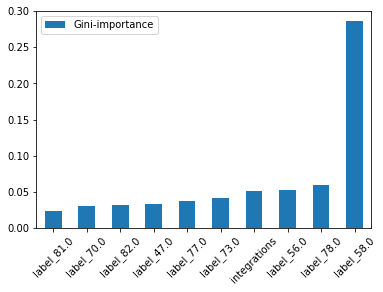

In [42]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(train_X.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').iloc[-10:].plot(kind='bar', rot=45)

In [43]:
print(entry_labels[58],entry_labels[78],entry_labels[56],entry_labels[73],entry_labels[82],entry_labels[77],entry_labels[70],entry_labels[47],entry_labels[81])

('changed organization', 'sms code', 'set form', 'updated Fixed Fee', 'signup', 'added recipient', 'cloned a new form', 'linked transaction', 'merchant account')


### Model with most important features from simple modeling

In [2]:
# list most import features
optimized_ftrs = [58, 78, 56, 73, 82, 77, 70, 47, 69]
optimized_ftrs_cols = ["label_{}.0".format(o_f) for o_f in optimized_ftrs]

# reformat dataset to include the most important features for the last 12 months of logs so that we have 1 row per organization
reformatted_data = []
for o in ftr_agged_df_qgiv['org'].unique():
    _df = ftr_agged_df_qgiv[ftr_agged_df_qgiv['org']==o][optimized_ftrs_cols+['integrations', 'org', 'reindex', 'churned']]
    
    _this_org_data = {}
    for _, r in _df.sort_values('reindex', ascending=True).iterrows():
        for c in _df.columns:
            if 'label_' in c:
                _this_org_data["month_{}_{}".format(r['reindex'], c.replace('.0', ''))] = r[c]
            elif c not in _this_org_data:
                _this_org_data[c] = r[c]
    reformatted_data.append(_this_org_data)
                
df_reformatted = pd.DataFrame(reformatted_data)
df_reformatted.head()

,churned,integrations,month_0_label_47,month_0_label_56,month_0_label_58,month_0_label_69,month_0_label_70,month_0_label_73,month_0_label_77,month_0_label_78,...,month_9_label_56,month_9_label_58,month_9_label_69,month_9_label_70,month_9_label_73,month_9_label_77,month_9_label_78,month_9_label_82,org,reindex
0,False,False,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,False,False,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,6,0
2,True,False,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,0
3,False,True,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,0
4,False,False,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33,0


In [45]:
# modeling qgiv
train_X, test_X, train_y, test_y = train_test_split(df_reformatted.drop(['org', 'churned', 'reindex'], axis=1).fillna(0.0), df_reformatted[target_col], test_size=0.33)

rf_qgiv = RandomForestClassifier(n_estimators=1000)
rf_qgiv.fit(train_X, train_y)

perc_churned = (float(np.sum(train_y) + np.sum(test_y)) / float(len(ftr_agged_df_qgiv['org'].unique()))) * 100.
print("Churned cases: {} training, {} testing, {:.2f}% of total".format(np.sum(train_y), np.sum(test_y), perc_churned))
print("Accuracy: {}".format(rf.score(test_X, test_y)))

y_pred = rf_qgiv.predict(test_X)
print(classification_report(test_y, y_pred))

Churned cases: 502 training, 237 testing, 17.60% of total
Accuracy: 0.91341991342
              precision    recall  f1-score   support

       False       0.91      0.99      0.95      1149
        True       0.93      0.54      0.68       237

   micro avg       0.91      0.91      0.91      1386
   macro avg       0.92      0.76      0.81      1386
weighted avg       0.91      0.91      0.90      1386



In [6]:
#joblib.dump(rf_qgiv, "rf_churn_qgiv.pkl")
rf_qgiv = joblib.load("rf_churn_qgiv.pkl")

## Prediction

In [7]:
import operator

In [8]:
y_pred = rf_qgiv.predict_proba(df_reformatted[~df_reformatted['churned']].drop(['org', 'churned', 'reindex'], axis=1).fillna(0.))

In [15]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df['org'] = df_reformatted[~df_reformatted['churned']]['org']
y_pred_df[~y_pred_df['org'].isnull()].sort_values(1, ascending=False).head()

,0,1,org
1183,0.015552,0.984448,139267.0
1881,0.086797,0.913203,438300.0
2323,0.145838,0.854162,441643.0
1616,0.145838,0.854162,430102.0
2277,0.145838,0.854162,441584.0


In [33]:
y_pred_orgs = [441401, 433162, 442575, 441589, 436234]
y_pred_orgs = y_pred_df[~y_pred_df['org'].isnull()].sort_values(1, ascending=False).head()['org']

for o in y_pred_orgs:
    inp = df_reformatted[df_reformatted['org']==o]
    
    print("Organization {}".format(int(o)))
    label_diffs = {}
    for c in inp.drop(['org', 'churned', 'reindex'], axis=1).columns:
        if c == 'integrations':
            print("\tintegrations: {}".format(inp[c].iloc[0]))
        else:
            label_diffs[c] = inp[c].fillna(0).iloc[0] - df_reformatted[c].mean()
    labels = ["label_18", "label_3", "label_4", "label_5", "label_58", "label_6", "label_7", "label_8", "label_9"]
    these_vals_means = {}
    for l in labels:
        these_vals = []
        for k in label_diffs.keys():
            if l in k:
                these_vals.append(label_diffs[k])
        
        these_vals_means[entry_labels[int(l.replace('label_', ''))]] = np.mean(these_vals)

    for e in sorted(these_vals_means.items(), key=lambda kv: kv[1]):
        if abs(e[1]) > 0.015:
            if e[1] > 0.:
                print("\t{} (up)".format(e[0]))
            else:
                print("\t{} (down)".format(e[0]))

Organization 139267
	integrations: False
	was donated to (down)
	changed organization (down)
	made a donation to (down)
	donated %amount (up)
	A donation was made to (down)
Organization 438300
	integrations: False
	was donated to (down)
	made a donation to (down)
	donated %amount (down)
	changed organization (down)
	A donation was made to (down)
Organization 441643
	integrations: False
	was donated to (down)
	donated %amount (down)
	made a donation to (down)
	A donation was made to (down)
Organization 430102
	integrations: False
	was donated to (down)
	changed organization (down)
	made a donation to (down)
	donated %amount (up)
	A donation was made to (up)
Organization 441584
	integrations: False
	was donated to (down)
	donated %amount (down)
	A donation was made to (down)
	changed organization (down)


## P2P

## Identify features with simple model

In [47]:
# modeling p2p
train_X, test_X, train_y, test_y = train_test_split(ftr_agged_df_p2p[ftr_cols], ftr_agged_df_p2p[target_col], test_size=0.33)

rf = RandomForestClassifier(n_estimators=1000)
rf.fit(train_X, train_y)

perc_churned = (float(np.sum(train_y) + np.sum(test_y)) / float(len(ftr_agged_df_p2p['org'].unique()))) * 100.
print("Churned cases: {} training, {} testing, {:.2f}% of total".format(np.sum(train_y), np.sum(test_y), perc_churned))
print("Accuracy: {}".format(rf.score(test_X, test_y)))

y_pred = rf.predict(test_X)
print(classification_report(test_y, y_pred))

Churned cases: 253 training, 107 testing, 69.50% of total
Accuracy: 0.933574879227
              precision    recall  f1-score   support

       False       0.94      1.00      0.97      1549
        True       0.29      0.02      0.04       107

   micro avg       0.93      0.93      0.93      1656
   macro avg       0.61      0.51      0.50      1656
weighted avg       0.89      0.93      0.91      1656



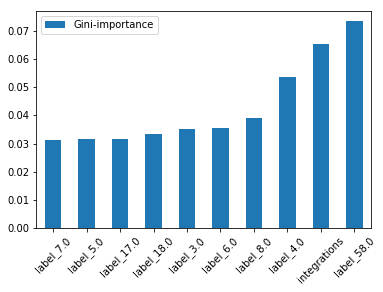

In [48]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(train_X.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').iloc[-10:].plot(kind='bar', rot=45)

In [49]:
print(entry_labels[58],entry_labels[4],entry_labels[3],entry_labels[8],entry_labels[7],entry_labels[6],entry_labels[18],entry_labels[5],entry_labels[20])

('changed organization', 'donated %amount', 'had the %badge', '% registered', 'A donation was made to', 'was donated to', 'Upload Your Avatar', 'made a donation to', 'Update Your Personal Page')


### Model from most important features from simple modeling

In [35]:
# list most import features
optimized_ftrs = [58, 4, 6, 5, 8, 18, 7, 3, 9]
optimized_ftrs_cols = ["label_{}.0".format(o_f) for o_f in optimized_ftrs]

# reformat dataset to include the most important features for the last 12 months of logs so that we have 1 row per organization
reformatted_data = []
for o in ftr_agged_df_p2p['org'].unique():
    _df = ftr_agged_df_p2p[ftr_agged_df_p2p['org']==o][optimized_ftrs_cols+['integrations', 'org', 'reindex', 'churned']]
    
    _this_org_data = {}
    for _, r in _df.sort_values('reindex', ascending=True).iterrows():
        for c in _df.columns:
            if 'label_' in c:
                _this_org_data["month_{}_{}".format(r['reindex'], c.replace('.0', ''))] = r[c]
            elif c not in _this_org_data:
                _this_org_data[c] = r[c]
    reformatted_data.append(_this_org_data)
                
df_reformatted = pd.DataFrame(reformatted_data)
df_reformatted.head()

,churned,integrations,month_0_label_18,month_0_label_3,month_0_label_4,month_0_label_5,month_0_label_58,month_0_label_6,month_0_label_7,month_0_label_8,...,month_9_label_3,month_9_label_4,month_9_label_5,month_9_label_58,month_9_label_6,month_9_label_7,month_9_label_8,month_9_label_9,org,reindex
0,False,True,0.00000,0.090909,0.272727,0.0,0.0,0.0,0.00000,0.090909,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,9,0
1,False,False,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,...,0.031746,0.373016,0.126984,0.0,0.047619,0.063492,0.047619,0.000000,13,0
2,False,False,0.00000,0.000000,1.000000,0.0,0.0,0.0,0.00000,0.000000,...,0.283298,0.169133,0.023256,0.0,0.002114,0.016913,0.010571,0.164905,53,0
3,False,False,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,76,0
4,False,False,0.02381,0.119048,0.000000,0.0,0.0,0.0,0.02381,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,87,0


In [65]:
# modeling p2p
train_X, test_X, train_y, test_y = train_test_split(df_reformatted.drop(['org', 'churned', 'reindex'], axis=1).fillna(0.0), df_reformatted[target_col], test_size=0.33)

rf_p2p = RandomForestClassifier(n_estimators=1000)
rf_p2p.fit(train_X, train_y)

perc_churned = (float(np.sum(train_y) + np.sum(test_y)) / float(len(ftr_agged_df_qgiv['org'].unique()))) * 100.
print("Churned cases: {} training, {} testing, {:.2f}% of total".format(np.sum(train_y), np.sum(test_y), perc_churned))
print("Accuracy: {}".format(rf.score(test_X, test_y)))

y_pred = rf_p2p.predict(test_X)
print(classification_report(test_y, y_pred))

Churned cases: 38 training, 17 testing, 1.31% of total
Accuracy: 0.912280701754
              precision    recall  f1-score   support

       False       0.92      0.99      0.95       154
        True       0.67      0.24      0.35        17

   micro avg       0.91      0.91      0.91       171
   macro avg       0.79      0.61      0.65       171
weighted avg       0.90      0.91      0.89       171



In [36]:
# joblib.dump(rf, "rf_churn_p2p.pkl")
rf_p2p = joblib.load("rf_churn_p2p.pkl")

## Prediction

In [37]:
y_pred = rf_p2p.predict_proba(df_reformatted[~df_reformatted['churned']].drop(['org', 'churned', 'reindex'], axis=1).fillna(0.))

In [39]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df['org'] = df_reformatted[~df_reformatted['churned']]['org']
y_pred_df[~y_pred_df['org'].isnull()].sort_values(1, ascending=False).head()

,0,1,org
285,0.414759,0.585241,441401.0
218,0.687502,0.312498,433162.0
421,0.705330,0.294670,442575.0
305,0.714180,0.285820,441589.0
227,0.724457,0.275543,436234.0


In [41]:
y_pred_orgs = [262148, 40985, 428063, 442575]
y_pred_orgs = y_pred_df[~y_pred_df['org'].isnull()].sort_values(1, ascending=False).head()['org']

for o in y_pred_orgs:
    inp = df_reformatted[df_reformatted['org']==o]
    
    print("Organization {}".format(int(o)))
    label_diffs = {}
    for c in inp.drop(['org', 'churned', 'reindex'], axis=1).columns:
        if c == 'integrations':
            print("\tintegrations: {}".format(inp[c].iloc[0]))
        else:
            label_diffs[c] = inp[c].fillna(0).iloc[0] - df_reformatted[c].mean()
    labels = ["label_18", "label_3", "label_4", "label_5", "label_58", "label_6", "label_7", "label_8", "label_9"]
    these_vals_means = {}
    for l in labels:
        these_vals = []
        for k in label_diffs.keys():
            if l in k:
                these_vals.append(label_diffs[k])
        
        these_vals_means[entry_labels[int(l.replace('label_', ''))]] = np.mean(these_vals)

    for e in sorted(these_vals_means.items(), key=lambda kv: kv[1]):
        if abs(e[1]) > 0.015:
            if e[1] > 0.:
                print("\t{} (up)".format(e[0]))
            else:
                print("\t{} (down)".format(e[0]))

Organization 441401
	integrations: True
	donated %amount (down)
	A donation was made to (down)
	changed organization (up)
	Upload Your Avatar (up)
	had the %badge (up)
	% registered (up)
Organization 433162
	integrations: True
	changed organization (down)
	made a donation to (down)
	% registered (down)
	donated %amount (up)
	had the %badge (up)
	joined %team (up)
Organization 442575
	integrations: False
	donated %amount (down)
	% registered (down)
	had the %badge (down)
	A donation was made to (down)
	changed organization (up)
Organization 441589
	integrations: False
	donated %amount (down)
	% registered (down)
Organization 436234
	integrations: False
	changed organization (down)
	% registered (down)
	made a donation to (down)
	had the %badge (down)
	joined %team (up)
	donated %amount (up)
